
# py-stepsimulator

This notebook is designed to be a user-friendly interface for generating and fitting Monte Carlo simulations of single-molecule stepping trajectories. When collecting single-molecule fluorescence or optical trapping data of stepping molecular motors, the time-series traces typically exhibit a stair-case pattern. For simplicity, this implementation assumes that the time-series exhibits the following characteristics:

   1. Exponentially distributed dwell-times.
   2. Gaussian sampled-white noise that is uncorrelated between different time-points
    
To get the most use out of this simulation, the user ideally should have collected single-molecule stepping traces and generated step-size/dwell-time histograms independently. Therefore, they can input simulation parameters that were observed experimentally. After inputting the simulation parameters, one can specify the number of Monte Carlo simulations to perform. In addition to the simulated trace, information about the simulated step locations is given. Furthermore, summary statistics of the step-sizes and dwell-times are generated.

In addition to the trace simulations, a step-fitting procedure is also performed. The algorithm used in this simulation implements iterative maximum-likelihood parameter estimation and the Schwarz Information Criterion (SIC) for model selection. Simulated traces are automatically fed into the step-fitter subroutine, step locations are predicted, and the step-size and dwell-time histograms are generated. These histograms can then be compared to the actual step-size and dwell-time histograms in order to determine the accuracy of the fitting procedure. In the cases where dwell-times are short, it is expected that the SIC algorithm will occasionally miss simulated steps. This information can be used to optimize the time-resolution of one's imaging experiment.

Algorithm Reference: Kalafut, Bennett, and Koen Visscher. Computer Physics Communications 179.10 (2008): 716-723
    
    

    

In [1]:
'''Import libraries'''

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mpld3
mpld3.enable_notebook()

import random
import math
import statsmodels.api as sm
from scipy.optimize import curve_fit


## Stepping Parameters

Next, we pass the expected stepping parameters that will be used to generate the simulated single-molecule traces. The user should modify the parameters below.

Different molecular motors in the cell exhibit distinct stepping patterns during single-molecule tracking experiments. Kinesin, for example, exhibits primarily 16 nm steps with little to no backward stepping. To simulate a kinesin stepping trace, the user should set the forward stepping frequency close to 1 and the backward stepping frequency close to 0. 

Conversely, dynein is a highly uncoordinated motor and has a large proporation of backwards steps. Accordingly, the user should change the stepping frequencies to reflect this experimental observation. The default currently is set to a 0.2/0.8 backwards/forwards stepping frequency, respectively.

In [31]:
''' 
    Initialize parameters

    Parameters
    ----------
    fwd_step_mu: float
        The expected mean forward step-size (nm)
        
    fwd_step_sigma: float
        The expected standard deviation of the forward step-size (nm)
        
    bkwd_step_mu: float
        The expected mean backward step-size (nm)
        
    bkwd_step_sigma: float
        The expected standard deviation of the backward step-size (nm)
        
    fwd_freq: float
        The expected frequency of forwards steps (nm)
        
    bkwd_freq: float
        The expected frequency of backwards steps (nm)
        
    kstep: float
        The expected stepping rate (s^-1)
        
    framerate: float
        The expected time resolution (s)
        
    sigma_noise: float
        The expected standard deviation of the trace noise
        
    nsteps: int
        Number of steps to be generated
        
    params: list
        An array of the above parameters
    
'''

fwdStepMu = 12
fwdStepSigma = 3

bkwdStepMu = 12
bkwdStepSigma = 3

fwdFreq = 0.72
bkwdFreq = 0.28

kStep = .5
frameRate = 0.03
sigmaNoise = 4

nSteps = 20

params = [fwdStepMu, 
          fwdStepSigma, 
          bkwdStepMu, 
          bkwdStepSigma, 
          fwdFreq,
          bkwdFreq,
          kStep, 
          frameRate,
          sigmaNoise, 
          nSteps]

## Simulating traces

The below function takes a list of stepping parameters and outputs a simulated trace with noise and an idealized trace without noise.

In [22]:
def buildTrace(*params):
    '''
        The main loop for building a single-molecule trace
        
        Parameters
        ----------
        params: list
            List of trace parameters required to generate the trace
    
        Returns
        -------
        trace: array
            Coordinates of a simulated trace
            
        ideal_trace: array
            Coordinates of simulated trace without noise
    '''
    
    trace = np.array([0])
    idealTrace = np.array([0])
    
    for step in range(0, nSteps):
       
        # Create dwell
        dwellLength = random.expovariate(1/kStep)
        dwellPts = int(dwellLength // frameRate)

        noise = np.random.normal(0, sigmaNoise, dwellPts)
        dwellNoise = np.full(dwellPts, trace[-1]) + noise
        trace = np.append(trace, dwellNoise)
        
        dwellIdeal = np.full(dwellPts, idealTrace[-1])
        idealTrace = np.append(idealTrace, dwellIdeal)
        
        # Add next step. Roll dice to decide step direction and then sample gaussian pdf for step-size
        prb = np.random.random_sample()
        
        if prb > bkwdFreq:
            stepDist = random.gauss(fwdStepMu, fwdStepSigma)
        elif prb <= bkwdFreq:
            stepDist = -random.gauss(bkwdStepMu, bkwdStepSigma)
        
        idealTrace[-1] += stepDist
        trace[-1] += stepDist     
        step += 1
    
    # Add final dwell
    dwellLength = random.expovariate(1 / kStep)
    dwellPts = int(dwellLength // frameRate)

    noise = np.random.normal(0, sigmaNoise, dwellPts)
    dwell = np.full(dwellPts, trace[-1]) + noise
    trace = np.append(trace, dwell)
    
    dwellIdeal = np.full(dwellPts, idealTrace[-1])
    idealTrace = np.append(idealTrace, dwellIdeal)
        
    return (idealTrace, trace)
        

## Step fitting
A simulated trace is passed into the fitSIC() function and a fit is generated.

In [23]:
def fitSIC(trace):
    '''Main function to fit the simulated traces using the SIC step-fitting algorithm
    
    Parameters
    ----------
    trace: array
        A numpy array of coordinates corresponding to simulated trace
        
    currSteps: list
        Array of indices of the recorded steps
        
    minThreshold: int
        Minimum number of points to be considered a dwell
        
    sicCurr: float
        Current minimized SIC value of fit
        
    Returns 
    ------- 
    fit: array
        A numpy array of coordinates corresponding to the optimal SIC fit   
        
    currSteps: array
        An array of currently defined steps
    '''
    currSteps = []
    minThreshold = 1
    
    nSteps = 0
    nPts = len(trace)
    
    # Calculate initial SIC value assuming no steps
    sicCurr = (nSteps + 2) * np.log(nPts) + nPts * np.log(np.var(trace)) + nPts

    while True:
        # Compute SIC and add new step
        (sicNew, newStepIdx) = logLikelihood(trace, currSteps, nPts, nSteps)
        if sicCurr >= sicNew:
            currSteps.append(newStepIdx)
            sicCurr = sicNew
            continue
        elif sicCurr < sicNew:
            break

    fit = plotFit(trace, currSteps)

    return (fit, currSteps)
  
        

def logLikelihood(trace, currSteps, nPts, nSteps):
    ''' Calculate the SIC static for all models with i steps. Identify position with minimum SIC
    
        Returns
        -------
        sic: float
            lowest SIC score 
            
        stepIdx: int
            Index of step that yielded the lowest SIC score       
    '''
    
    sicArray = np.zeros(nPts)
    
    for step in range(0,nPts):
        # Skip currently stored steps
        if step in currSteps:
            continue
        
        # Skip first data point to avoid empty array slice
        if step == 0:
            continue
            
        # Set new step at current point and calculate global variance of all dwells.
        temp = currSteps + [step]
        traceSplit = np.split(trace, np.sort(temp))
        dwellVar = [np.var(traceSplit[j]) * len(traceSplit[j]) for j in range(0, len(traceSplit))]
        varEstimate = (1 / nPts) * sum(dwellVar)

        # Compute SIC score and collect it into an array
        nSteps = len(traceSplit) - 1
        sic = (nSteps + 2) * np.log(nPts) + nPts * np.log(varEstimate)
        sicArray[step] = sic
        
    
    # Compute minimum SIC score and step position
    mask = (sicArray != 0)
    truncStepIdx = np.argmin(sicArray[mask])
    stepIdx = np.arange(sicArray.shape[0])[mask][truncStepIdx]
    sicMin = sicArray[stepIdx]

    return (sicMin, stepIdx)
   

def plotFit(trace, currSteps):
    '''Construct the optimal SIC fit and plot it. Output the fit coordinates
    
        Returns
        -------
        fit_func: array
            A numpy array of the fit coordinates 
    '''
    fitSplit = np.split(trace,np.sort(currSteps))
    dwellMeans = np.array([np.mean(fitSplit[i]) for i in range(0,len(fitSplit))])
    dwellFit = [dwellMeans[j]*np.ones(len(fitSplit[j])) for j in range(0,len(fitSplit))]
    fitFunc = np.concatenate(dwellFit)
    
    return fitFunc
  
        

## Implementing simulation and fitting procedures

Below, we select the number of traces we wish to simulate and fit. The data is stored into several pandas DataFrames for later analysis.

In [32]:
''' 
    Create a group of traces (specified by ntraces) and place into
    a pandas dataframe. Then generate fits and place into a separate data 
    frame 
'''

nTraces = 5
traces = pd.DataFrame()
idealTraces = pd.DataFrame()
fits = pd.DataFrame()

for i in range(0, nTraces):

    print('Generating simulated trace {0}'.format(i))
    (idealTrace, trace) = buildTrace(*params)
    idealTraces[str(i)] = pd.Series(idealTrace)
    traces[str(i)] = pd.Series(trace)
    
    print('Fitting trace {0}...'.format(i))
    (fit, currSteps) = fitSIC(trace)
    fits[str(i)] = pd.Series(fit)

print('Done!')

Generating simulated trace 0
Fitting trace 0...
Generating simulated trace 1
Fitting trace 1...
Generating simulated trace 2
Fitting trace 2...
Generating simulated trace 3
Fitting trace 3...
Generating simulated trace 4
Fitting trace 4...
Done!


## Data Visualization

After generating all the traces and fits, lets plot selected traces. 
To select a trace to display, set the value of 'which_trace' to the desired trace number.

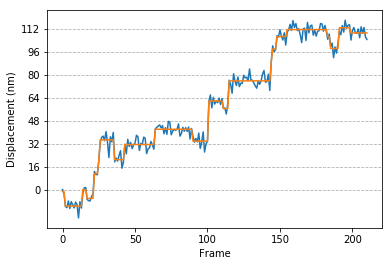

In [28]:
''' Plot desired trace and corresponding fit'''

# Select desired trace number to view
whichTrace = 0

# Plot selected trace and fit
plt.plot(traces['{0}'.format(whichTrace)])
plt.plot(fits['{0}'.format(whichTrace)])
plt.ylabel('Displacement (nm)')
plt.yticks(np.arange(0, max(traces['{0}'.format(whichTrace)])+1, 16))
plt.grid(True,axis='y',linestyle='--')
plt.xlabel('Frame')

plt.show()

## Generating Statistics

Next, we will define functions to assemble a list of dwell times and step sizes for the simulated ideal traces and the noisy fitted traces.

In [41]:
 def assembleSteps(nTraces, fits):
        '''Create array of all step-sizes. Create DataFrame of binary arrays for step locations.

        Parameters
        ----------
        nTraces: int
            Number of traces
            
        fits: DataFrame
            DataFrame of coordinates of either idealized trace or fit

        Returns
        -------
        allSteps: list
            List of all steps. Each element is a step-size in (nm)
            
        stepLocation: pandas DataFrame
            A DataFrame of binary arrays where 1s correpsond to step locations

        '''  
        # Calculate all steps
        allSteps = []
        stepLocation = pd.DataFrame()

        for i in range(0, nTraces):
            fit = fits.iloc[:,i]

            # Add steps to array
            fitSteps = [fit[j] - fit[j-1] for j in range(1,len(fit)) if fit[j] - fit[j - 1] != 0
                             and math.isnan(fit[j] - fit[j - 1]) != True]
            allSteps += fitSteps

            # Create binary array of step locations
            fitStepLocs = [1 if (fit[j] - fit[j - 1] != 0 and math.isnan(fit[j] - fit[j - 1]) != True) else 0 
                                 for j in range(1,len(fit))]
            stepLocation['{0}'.format(i)] = fitStepLocs

        return (allSteps,stepLocation)
    
    
def assembleDwells(nTraces, stepLocation, rate):
        '''Assemble dwells of all step locations

        Parameters
        ----------
        nTraces: int
            Number of traces
            
        stepLocation: DataFrame
            DataFrame of binary arrays where 1s correspond to step locations
            
        rate: int
            Time resolution of the simulation (in seconds)

        Returns
        -------
        allDwellsConverted: list
            List of integers corresponding to length of a dwell (in seconds)
            
        '''
        allDwells = []

        for i in range(0, nTraces):
            fitBinary = stepLocation.iloc[:,i]

            dwells = np.split(fitBinary, np.where(fitBinary == 1)[0])
            allDwells += [len(dwells[j]) for j in range(0, len(dwells))]

        # Convert from frames to seconds
        allDwellsConverted = [i*rate for i in allDwells]
        return allDwellsConverted
    
    
def stats(allSteps, allDwells):
        '''Compute important statistics of the time-series.

        Parameters
        ----------
        allSteps :  list 
            A list of jump-point sizes. Units are 'nm'.
            
        allDwells :  list
            A List of dwell times betwen jump-points.
            Units are 's'.

        Returns
        -------
        stats: list
            A list of the parameters listed below.
            
        fwdMu: float
            Mean of forward step-size

        bkwdMu: float
            Mean of backwards step-size

        fwdtd: float
            Standard deviation of forwards step-size

        bkwd_std: float
            Standard deviation of backwards step-size
            
        fwd_freq: float
            Frequency of forward steps
            
        bkwd_freq: float
            Frequency of backward steps
            
        dwell_k: float
            Dwell-time distribution rate constant 
            
        dwell_params: list

        '''
        # Calculate stepping parameters
        fwdSteps = [i for i in allSteps if i >= 0]
        bkwdSteps = [i for i in allSteps if i < 0]

        fwdMu = np.mean(fwdSteps)
        bkwdMu = np.mean(bkwdSteps)

        fwdStd = np.std(fwdSteps)
        bkwdStd = np.std(bkwdSteps)

        fwdFreq = len(fwdSteps) / (len(fwdSteps) + len(bkwdSteps))
        bkwdFreq = 1 - fwdFreq

        # Calculate dwell parameters
        ecdf = sm.distributions.ECDF(allDwells)
        x_c = ecdf.x[1:]
        y_c = 1 - ecdf.y[1:]

        def func(x, a, b, c):
            return a * np.exp(-b * x) + c

        popt, pcov = curve_fit(func, x_c, y_c, p0=[1,1,0])
        f = popt[0] * np.exp(-popt[1] * x_c) + popt[2]
        dwellConstant = 1 / popt[1]

        dwellParams = [x_c,y_c,f]
        stats = [fwdMu, fwdStd, bkwdMu, bkwdStd, fwdFreq, bkwdFreq, dwellConstant]
        
        return (stats, dwellParams)


## Data Visualization

Next, we will plot both the step-size distributions and the dwell-time distributions for both the simulated traces and the SIC fits. Then, we generate survival-probabilities of the dwell-times by calculating the empirical cumulative distribution function.

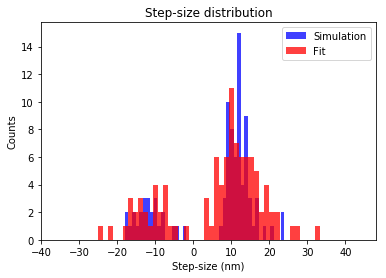

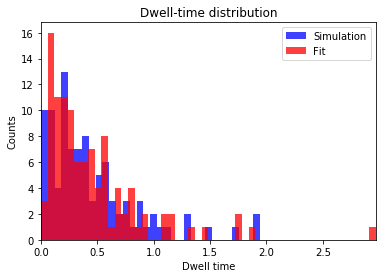

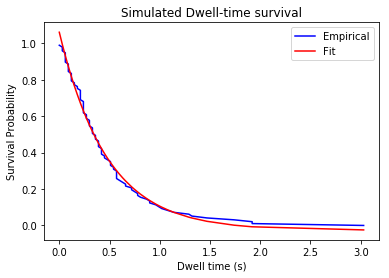

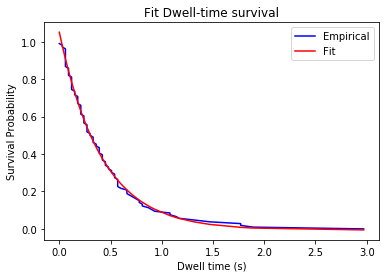

In [42]:
# Assemble steps and dwell-times from simulations
(allIdealSteps,idealStepLocation) = assembleSteps(nTraces, idealTraces)
allIdealDwells = assembleDwells(nTraces, idealStepLocation, frameRate)
(idealStats, idealDwellParams) = stats(allIdealSteps, allIdealDwells)


# Assemble steps and dwell-times from fits
(allSteps, fitStepLocation) = assembleSteps(nTraces, fits)
allDwells = assembleDwells(nTraces, fitStepLocation, frameRate)
(stats, dwellParams) = stats(allSteps, allDwells)


# Plot histogram of step size 
plt.hist(allIdealSteps, 44, facecolor='blue', alpha=0.75,label='Simulation')
plt.hist(allSteps, 44, facecolor='red', alpha=0.75,label='Fit')
plt.xlim(-40,48)
plt.xlabel('Step-size (nm)')
plt.ylabel('Counts')
plt.xticks
plt.legend()
plt.title('Step-size distribution')
plt.show()

# Plot histogram of dwell-times
plt.hist(allIdealDwells, 50, facecolor='blue', alpha=0.75,label='Simulation')
plt.hist(allDwells, 50, facecolor='red', alpha=0.75,label='Fit')
plt.xlim(0,max(allDwells))
plt.xlabel('Dwell time')
plt.ylabel('Counts')
plt.legend()
plt.title('Dwell-time distribution')
plt.show()

# Plot dwell-times
x_c = idealDwellParams[0]
y_c = idealDwellParams[1]
f = idealDwellParams[2]
plt.plot(x_c,y_c,'b',label='Empirical')
plt.plot(x_c,f,'r',label='Fit')
plt.xlabel('Dwell time (s)')
plt.ylabel('Survival Probability')
plt.legend()
plt.title('Simulated Dwell-time survival')
plt.show()

x_c = dwellParams[0]
y_c = dwellParams[1]
f = dwellParams[2]
plt.plot(x_c,y_c,'b',label='Empirical')
plt.plot(x_c,f,'r',label='Fit')
plt.xlabel('Dwell time (s)')
plt.ylabel('Survival Probability')
plt.legend()
plt.title('Fit Dwell-time survival')
plt.show()

## Exporting Data

Finally, we export the traces and statistics into separate .csv files. The file names are given as follows:


| File Name                | Description                              |
|:-------------------------|:-----------------------------------------|
| **ideal_traces.csv**     | Coordinates of simulations without noise |
| **withnoise_traces.csv** | Coordinates of simulations with noise    |   
| **fits.csv**             | Coordinates of SIC fits                  |
| **ideal_stepsizes.csv**  | List of step-sizes (in nm) from simulations without noise |
| **fit_stepsizes.csv**    | List of step-sizes (in nm) from SIC fits                  |   
| **ideal_dwells.csv**     | List of dwell-times (in s) from simulations without noise |
| **fit_dwells.csv**       | List of dwell-times (in s) from SIC fits                  |
| **ideal_statistics.csv** | List of statistics generated from the simulated traces    |
| **statistics.csv**       | List of statistics generated from the fitted traces       |
| **parameters.csv**       | List of parameters used as inputs for the simulation      |

   
   


In [69]:
'''
Output the traces and the fits as tab-delimited .csv files.
Save the histogram statistics into a single .csv file. Save figures of traces 
and of the histograms.

'''

# Save traces and fits
ideal_traces.to_csv('ideal_traces.csv',sep='\t')
traces.to_csv('withnoise_traces.csv',sep='\t')
fits.to_csv('fits.csv',sep='\t')

# Save step-size and step locations
np.savetxt('ideal_stepsizes.csv',np.asarray(all_ideal_steps),delimiter='\t')
np.savetxt('fit_stepsizes.csv',np.asarray(all_steps),delimiter='\t')

np.savetxt('ideal_steplocs.csv',np.asarray(ideal_step_location),delimiter='\t')
np.savetxt('fit_steplocs.csv',np.asarray(fit_step_location),delimiter='\t')

# Save dwells
np.savetxt('ideal_dwells.csv',np.asarray(all_ideal_dwells),delimiter='\t')
np.savetxt('fit_dwells.csv',np.asarray(all_dwells),delimiter='\t')

#Save statistics
stats_df = pd.Series(ideal_stats,index=['Fwd Avg.','Fwd Std.','Bkwd Avg.','Bkwd Std.','Fwd Freq.','Bkwd Freq.',
                                     'Dwell constant'])
stats_df.to_csv('ideal_statistics.csv',sep='\t')

stats_df = pd.Series(stats,index=['Fwd Avg.','Fwd Std.','Bkwd Avg.','Bkwd Std.','Fwd Freq.','Bkwd Freq.',
                                     'Dwell constant'])
stats_df.to_csv('statistics.csv',sep='\t')

# Save parameter list 
params_df = pd.Series(params,index=['Fwd Avg.','Fwd. Std.','Bkwd Avg.','Bkwd Std.','Fwd Freq.','Bkwd Freq.',
                                        'Dwell constant','Frame rate (s)','Noise Std.','N steps'])
params_df.to_csv('parameters.csv',sep='\t')